In [1]:
import pandas as pd
from itertools import permutations
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import pybedtools as pbt

1. Affected bins contain more SNPs with negative effect on motif matches - within +/- 500bp from DNase peak summit.
2. In the same range there is significant difference in alleleDiff values (for positive alleleDiff).
3. And there are some TFs which are significantly affected.

# Prepare files with SNPs

In [2]:
#Input
DATA = "../../data/"
INPUT_VCF = DATA + "external_WGS/vcf/D_mel_DGRP-57_DGRP-439.SNPs.filter.vcf.gz"

In [12]:
#Output
tables = "../../results/csv/"
figures = "../../results/fig/"
bedfiles = "../../results/bed/"

Read DEseq results from which affected/compensating haplotype can be identified.

In [4]:
def find_affected_locus_and_directions(row):
    #on the allele indicated in pair name but on the other locus
    affected_allele = row.name.split("_")[0]
    if row.name.split("_")[1] == "locus1":
        unaffected_locus = row["bin_name1"]
        affected_locus = row["bin_name2"]
    elif row.name.split("_")[1] == "locus2":
        affected_locus = row["bin_name1"]
        unaffected_locus = row["bin_name2"]
    else:
        print(row.name.split("_")[1])
    if row["log2FoldChange"] > 0:
        direction = "UP"
    elif row["log2FoldChange"] < 0:
        direction = "DOWN"
    
    row["affected_allele"] = affected_allele
    row["affected_locus_coordinates"] = affected_locus
    row["unaffected_locus_coordinates"] = unaffected_locus
    row["direction"] = direction
    
    return row

In [5]:
significant_pairs = pd.read_csv(tables + "WE_diff_bin_pairs.csv", sep = "\t", index_col = 0)
significant_pairs["bin_name1"] = "chr" + significant_pairs.index.str.split("_chr").str[1]
significant_pairs["bin_name2"] = "chr" + significant_pairs.index.str.split("_chr").str[2]
significant_pairs = significant_pairs.apply(find_affected_locus_and_directions, axis=1)
significant_pairs.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,bin_name1,bin_name2,affected_allele,affected_locus_coordinates,unaffected_locus_coordinates,direction
DGRP-57_locus1_chr2L:10000000-10002500_chr2L:10002500-10005000,11.328060,-3.026789,1.058510,-2.859482,0.004243,0.045783,chr2L:10000000-10002500,chr2L:10002500-10005000,DGRP-57,chr2L:10002500-10005000,chr2L:10000000-10002500,DOWN
DGRP-57_locus1_chr2L:10025000-10027500_chr2L:10027500-10030000,4.884034,-4.421116,1.483977,-2.979234,0.002890,0.044235,chr2L:10025000-10027500,chr2L:10027500-10030000,DGRP-57,chr2L:10027500-10030000,chr2L:10025000-10027500,DOWN
DGRP-57_locus1_chr2L:10190000-10192500_chr2L:10197500-10200000,3.908042,-4.106179,1.494520,-2.747490,0.006005,0.046718,chr2L:10190000-10192500,chr2L:10197500-10200000,DGRP-57,chr2L:10197500-10200000,chr2L:10190000-10192500,DOWN
DGRP-57_locus1_chr2L:10210000-10212500_chr2L:10217500-10220000,3.973403,-4.134231,1.499326,-2.757392,0.005826,0.046499,chr2L:10210000-10212500,chr2L:10217500-10220000,DGRP-57,chr2L:10217500-10220000,chr2L:10210000-10212500,DOWN
DGRP-57_locus1_chr2L:10212500-10215000_chr2L:10215000-10217500,11.605186,-2.394369,0.878435,-2.725720,0.006416,0.046838,chr2L:10212500-10215000,chr2L:10215000-10217500,DGRP-57,chr2L:10215000-10217500,chr2L:10212500-10215000,DOWN


In [6]:
significant_pairs[(significant_pairs["bin_name1"] == "chr3L:5925000-5927500") | (significant_pairs["bin_name2"] == "chr3L:5925000-5927500")]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,bin_name1,bin_name2,affected_allele,affected_locus_coordinates,unaffected_locus_coordinates,direction
DGRP-57_locus1_chr3L:5925000-5927500_chr3L:18957500-18960000,5.566847,7.332560,1.549259,4.732946,2.212846e-06,0.000501,chr3L:5925000-5927500,chr3L:18957500-18960000,DGRP-57,chr3L:18957500-18960000,chr3L:5925000-5927500,UP
DGRP-57_locus1_chr3L:5925000-5927500_chr3L:18960000-18962500,10.549070,8.251026,1.507811,5.472189,4.445115e-08,0.000019,chr3L:5925000-5927500,chr3L:18960000-18962500,DGRP-57,chr3L:18960000-18962500,chr3L:5925000-5927500,UP
DGRP-439_locus2_chr3L:5925000-5927500_chr3L:18957500-18960000,5.566847,7.332560,1.549259,4.732946,2.212846e-06,0.000501,chr3L:5925000-5927500,chr3L:18957500-18960000,DGRP-439,chr3L:5925000-5927500,chr3L:18957500-18960000,UP
DGRP-439_locus2_chr3L:5925000-5927500_chr3L:18960000-18962500,10.549070,8.251026,1.507811,5.472189,4.445115e-08,0.000019,chr3L:5925000-5927500,chr3L:18960000-18962500,DGRP-439,chr3L:5925000-5927500,chr3L:18960000-18962500,UP


Read dataframe with contacts assigned to bins and with std for contact positions. This df contains only significant DESeq results.

In [7]:
contacts_in_significant_pairs = pd.read_csv(tables + "WE_positions_std.csv", sep = "\t")
contacts_in_significant_pairs.head()

,chrom,pos1,strand1,h1,pos2,strand2,h2,transh,pos1-1,pos2-1,interactionID,replicate,dist,bin_name1,bin_name2,bin pair type,std1,std2,num_contacts
0,chr2L,10000460,+,DGRP-57,10002717,-,DGRP-57,False,10000459,10002716,93553,Rep1,2257,chr2L:10000000-10002500,chr2L:10002500-10005000,transDOWN,732.88617,639.025214,210
1,chr2L,10000646,DGRP-57,DGRP-57,10003143,DGRP-57,DGRP-57,False,10000645,10003142,158488,Rep1,2497,chr2L:10000000-10002500,chr2L:10002500-10005000,transDOWN,732.88617,639.025214,210
2,chr2L,10001136,DGRP-57,DGRP-57,10004253,DGRP-57,DGRP-57,False,10001135,10004252,186509,Rep1,3117,chr2L:10000000-10002500,chr2L:10002500-10005000,transDOWN,732.88617,639.025214,210
3,chr2L,10000483,-,DGRP-57,10003916,+,DGRP-57,False,10000482,10003915,448998,Rep1,3433,chr2L:10000000-10002500,chr2L:10002500-10005000,transDOWN,732.88617,639.025214,210
4,chr2L,10002350,DGRP-57,DGRP-57,10004194,DGRP-57,DGRP-57,False,10002349,10004193,901009,Rep1,1844,chr2L:10000000-10002500,chr2L:10002500-10005000,transDOWN,732.88617,639.025214,210


Filter SNPs differentiating the haplotypes.

In [8]:
def create_files(filename, bin_status, allele, affected="affected"):
    
    alleles = ["DGRP-57", "DGRP-439"]
    
    #select intervals file for affected or unaffected bin
    if affected=="affected":
        coordinates_list = tables + "tmp/%s_%s_bin_coords.%s-%s.list" % (filename, bin_status, allele, affected)
    elif affected=="CTRL":
        alleles.remove(allele)
        affected_allele = alleles[0]
        coordinates_list = tables + "tmp/%s_%s_bin_coords.%s-%s.list" % (filename, bin_status, affected_allele, "affected")
        
    #define output files names; vcf and csv are temp files and are removed when bed file is ready    
    snps_vcf = tables + "tmp/%s.%s_bin.%s-%s.SNPs.vcf.gz" % (filename, bin_status, allele, affected)
    snps_csv = tables + "tmp/%s.%s_bin.%s-%s.SNPs.csv" % (filename, bin_status, allele, affected)
    snps_bed = bedfiles + "%s.%s_bin.%s-%s.SNPs.bed" % (filename, bin_status, allele, affected)
    print(coordinates_list)
    print(snps_vcf, snps_csv, snps_bed)
    
    #select SNPs located in analyzed intervals
    select_log = ! /home/magda/gatk-4.2.4.0/gatk SelectVariants \
    -V $INPUT_VCF \
    -L $coordinates_list \
    --sample-name $allele \
    --exclude-non-variants \
    -O $snps_vcf

    
    #reformat to csv and then to bed
    totable_log = ! /home/magda/gatk-4.2.4.0/gatk VariantsToTable \
    -V $snps_vcf \
    -F CHROM -F POS -F REF -F ALT -GF GT \
    -O $snps_csv

    snps_df = pd.read_csv(snps_csv, sep = "\t")    
    snps_bed_df = pd.DataFrame()
    snps_bed_df["chromosome"] = "chr" + snps_df["CHROM"]
    snps_bed_df["start"] = snps_df["POS"] - 1
    snps_bed_df["end"] = snps_df["POS"]
    snps_bed_df["name"] = snps_df["CHROM"] + ":" + snps_df["POS"].astype(str) + ":" + snps_df["REF"] + ":" + snps_df["ALT"]
    snps_bed_df["score"] = 0
    snps_bed_df["strand"] = "+"
    
    snps_bed_df.to_csv(snps_bed, sep="\t", index=False, header=False) 
    

In [13]:
!mkdir $tables/tmp

In [14]:
#to prepare SNPs from affected and unaffected haplotype in the affected bin we need to group
#the data both by direction and affected allele
for name, group in significant_pairs.groupby(["direction", "affected_allele"]):
    print(name)
    direction, affected_allele = name
    filename = "WE_trans" + direction

    if affected_allele == "DGRP-57":
        unaffected_allele = "DGRP-439"
    elif affected_allele == "DGRP-439":
        unaffected_allele = "DGRP-57" 

    #the "0" coordinate is not accepted by GATK SelectVariants - replace it by "1"
    group["affected_locus_coordinates"] = group["affected_locus_coordinates"].str.replace(":0-", ":1-", regex = True)
    group["unaffected_locus_coordinates"] = group["unaffected_locus_coordinates"].str.replace(":0-", ":1-", regex = True)

    #create coords list files for affected and unaffected bins
    group["affected_locus_coordinates"].str[3:].to_csv(tables + "tmp/%s_%s_bin_coords.%s-%s.list" % (filename, "affected", affected_allele, "affected"), 
                                                        sep = "\t", index=False, header=False)
    group["unaffected_locus_coordinates"].str[3:].to_csv(tables + "tmp/%s_%s_bin_coords.%s-%s.list" % (filename, "unaffected", affected_allele, "affected"), 
                                                        sep = "\t", index=False, header=False)
        
    #select SNPs from appropriate bins and haplotypes     
    bin_status = "affected"
    #for "haplotype comparison" generale vcfs for each haplotype, for affected locus only
    for allele, affected_status in [(affected_allele, "affected"), (unaffected_allele, "CTRL")]:
        print(filename, bin_status, allele, affected_status)
        create_files(filename, bin_status, allele, affected = affected_status)
            
    bin_status = "unaffected"
    create_files(filename, bin_status, affected_allele, affected = "affected")

('DOWN', 'DGRP-439')
WE_transDOWN affected DGRP-439 affected
../../results_final/csv/tmp/WE_transDOWN_affected_bin_coords.DGRP-439-affected.list
../../results_final/csv/tmp/WE_transDOWN.affected_bin.DGRP-439-affected.SNPs.vcf.gz ../../results_final/csv/tmp/WE_transDOWN.affected_bin.DGRP-439-affected.SNPs.csv ../../results_final/bed/WE_transDOWN.affected_bin.DGRP-439-affected.SNPs.bed
WE_transDOWN affected DGRP-57 CTRL
../../results_final/csv/tmp/WE_transDOWN_affected_bin_coords.DGRP-439-affected.list
../../results_final/csv/tmp/WE_transDOWN.affected_bin.DGRP-57-CTRL.SNPs.vcf.gz ../../results_final/csv/tmp/WE_transDOWN.affected_bin.DGRP-57-CTRL.SNPs.csv ../../results_final/bed/WE_transDOWN.affected_bin.DGRP-57-CTRL.SNPs.bed
../../results_final/csv/tmp/WE_transDOWN_unaffected_bin_coords.DGRP-439-affected.list
../../results_final/csv/tmp/WE_transDOWN.unaffected_bin.DGRP-439-affected.SNPs.vcf.gz ../../results_final/csv/tmp/WE_transDOWN.unaffected_bin.DGRP-439-affected.SNPs.csv ../../result

Remove temp. files.

In [15]:
!rm -r $tables/tmp

# Prepare "personalized" genomes for SNPs analysis

Use fasta files representing sequences of the DGRP-57 and DGRP-439 haplotypes (only SNPs included) to create a BSgenome R object which could be used by motifbreakR.  
BSgenome instruction: https://bioconductor.org/packages/3.16/bioc/vignettes/BSgenome/inst/doc/BSgenomeForge.pdf

**Updated fasta files (18.02.2025):**

In [16]:
!cp /home/ajank/TransContactHiC/data/external_WGS/fasta/D_mel_DGRP-57_DGRP-439_maternal.fa.gz ../../data/DGRP-57_DGRP-439_genomes/DGRP-57/

In [17]:
!cp /home/ajank/TransContactHiC/data/external_WGS/fasta/D_mel_DGRP-57_DGRP-439_paternal.fa.gz ../../data/DGRP-57_DGRP-439_genomes/DGRP-439/

In [18]:
!gunzip ../../data/DGRP-57_DGRP-439_genomes/DGRP-439/D_mel_DGRP-57_DGRP-439_paternal.fa.gz

In [19]:
!gunzip ../../data/DGRP-57_DGRP-439_genomes/DGRP-57/D_mel_DGRP-57_DGRP-439_maternal.fa.gz

In [20]:
from Bio import SeqIO

In [21]:
for rec in SeqIO.parse(open("../../data/DGRP-57_DGRP-439_genomes/DGRP-439/D_mel_DGRP-57_DGRP-439_paternal.fa"), "fasta"):
    if rec.id in ["2L", "2R", "3L", "3R", "4", "X", "Y"]:
        out = open("../../data/DGRP-57_DGRP-439_genomes/DGRP-439/chr%s.fa" % rec.id, "w")
        out.write(">chr" + rec.id + "\n" + str(rec.seq))
        out.close()

In [22]:
!rm ../../data/DGRP-57_DGRP-439_genomes/DGRP-439/D_mel_DGRP-57_DGRP-439_paternal.fa

In [23]:
for rec in SeqIO.parse(open("../../data/DGRP-57_DGRP-439_genomes/DGRP-57/D_mel_DGRP-57_DGRP-439_maternal.fa"), "fasta"):
    if rec.id in ["2L", "2R", "3L", "3R", "4", "X", "Y"]:
        out = open("../../data/DGRP-57_DGRP-439_genomes/DGRP-57/chr%s.fa" % rec.id, "w")
        out.write(">chr" + rec.id + "\n" + str(rec.seq))
        out.close()

In [24]:
!rm ../../data/DGRP-57_DGRP-439_genomes/DGRP-57/D_mel_DGRP-57_DGRP-439_maternal.fa

In [25]:
%load_ext rpy2.ipython

In [26]:
%%R
library(Biostrings)
library(BSgenome)

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, w

## DGRP-57

The seed files have been created manually. The contents of the BSgenome.Dmelanogaster.custom.dgrp57-seed file:

In [30]:
%%R
forgeBSgenomeDataPkg("../../data/DGRP-57_DGRP-439_genomes/DGRP-57/BSgenome.Dmelanogaster.custom.dgrp57-seed", 
                     destdir="../../data/DGRP-57_DGRP-439_genomes")

Creating package in ../../data/DGRP-57_DGRP-439_genomes/BSgenome.Dmelanogaster.custom.dgrp57 
Loading 'chr2L' sequence from FASTA file '../../data/DGRP-57_DGRP-439_genomes/DGRP-57/chr2L.fa' ... DONE
Loading 'chr2R' sequence from FASTA file '../../data/DGRP-57_DGRP-439_genomes/DGRP-57/chr2R.fa' ... DONE
Loading 'chr3L' sequence from FASTA file '../../data/DGRP-57_DGRP-439_genomes/DGRP-57/chr3L.fa' ... DONE
Loading 'chr3R' sequence from FASTA file '../../data/DGRP-57_DGRP-439_genomes/DGRP-57/chr3R.fa' ... DONE
Loading 'chr4' sequence from FASTA file '../../data/DGRP-57_DGRP-439_genomes/DGRP-57/chr4.fa' ... DONE
Loading 'chrX' sequence from FASTA file '../../data/DGRP-57_DGRP-439_genomes/DGRP-57/chrX.fa' ... DONE
Loading 'chrY' sequence from FASTA file '../../data/DGRP-57_DGRP-439_genomes/DGRP-57/chrY.fa' ... DONE
Writing all sequences to '../../data/DGRP-57_DGRP-439_genomes/BSgenome.Dmelanogaster.custom.dgrp57/inst/extdata/single_sequences.2bit' ... DONE


In [31]:
!R CMD build ../../data/DGRP-57_DGRP-439_genomes/BSgenome.Dmelanogaster.custom.dgrp57

* checking for file ‘../../data/DGRP-57_DGRP-439_genomes/BSgenome.Dmelanogaster.custom.dgrp57/DESCRIPTION’ ... OK
* preparing ‘BSgenome.Dmelanogaster.custom.dgrp57’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘BSgenome.Dmelanogaster.custom.dgrp57_1.0.tar.gz’



In [32]:
!R CMD check BSgenome.Dmelanogaster.custom.dgrp57_1.0.tar.gz

* using log directory ‘/mnt/chr12/Data/magda/MultiWayHiC/src/jupyter_ready/BSgenome.Dmelanogaster.custom.dgrp57.Rcheck’
* using R version 4.0.0 (2020-04-24)
* using platform: x86_64-conda_cos6-linux-gnu (64-bit)
* using session charset: UTF-8
* checking for file ‘BSgenome.Dmelanogaster.custom.dgrp57/DESCRIPTION’ ... OK
* this is package ‘BSgenome.Dmelanogaster.custom.dgrp57’ version ‘1.0’
* checking package namespace information ... OK
* checking package dependencies ... OK
* checking if this is a source package ... OK
* checking if there is a namespace ... OK
* checking for executable files ... OK
* checking for hidden files and directories ... OK
* checking for portable file names ... OK
* checking for sufficient/correct file permissions ... OK
* checking whether package ‘BSgenome.Dmelanogaster.custom.dgrp57’ can be installed ... WARNING
Found the following significant warnings:
See ‘/mnt/chr12/Data/magda/MultiWayHiC/src/jupyter_ready/BSgenome.Dmelanogaster.custom.dgrp57.Rcheck/00ins

In [33]:
!R CMD INSTALL BSgenome.Dmelanogaster.custom.dgrp57_1.0.tar.gz

* installing to library ‘/home/magda/miniconda3/lib/R/library’
* installing *source* package ‘BSgenome.Dmelanogaster.custom.dgrp57’ ...
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
Warning messages:
1: package ‘BSgenome’ was built under R version 4.0.2 
2: package ‘BiocGenerics’ was built under R version 4.0.2 
3: package ‘S4Vectors’ was built under R version 4.0.2 
4: package ‘IRanges’ was built under R version 4.0.2 
5: package ‘GenomeInfoDb’ was built under R version 4.0.2 
6: package ‘GenomicRanges’ was built under R version 4.0.2 
7: package ‘Biostrings’ was built under R version 4.0.2 
8: package ‘XVector’ was built under R version 4.0.2 
9: package ‘rtracklayer’ was built under R version 4.0.2 
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a

## DGRP-439

The seed files have been created manually. The contents of the BSgenome.Dmelanogaster.custom.dgrp439-seed file:

In [34]:
%%R
forgeBSgenomeDataPkg("../../data/DGRP-57_DGRP-439_genomes/DGRP-439/BSgenome.Dmelanogaster.custom.dgrp439-seed",
                    destdir="../../data/DGRP-57_DGRP-439_genomes")

Creating package in ../../data/DGRP-57_DGRP-439_genomes/BSgenome.Dmelanogaster.custom.dgrp439 
Loading 'chr2L' sequence from FASTA file '../../data/DGRP-57_DGRP-439_genomes/DGRP-439/chr2L.fa' ... DONE
Loading 'chr2R' sequence from FASTA file '../../data/DGRP-57_DGRP-439_genomes/DGRP-439/chr2R.fa' ... DONE
Loading 'chr3L' sequence from FASTA file '../../data/DGRP-57_DGRP-439_genomes/DGRP-439/chr3L.fa' ... DONE
Loading 'chr3R' sequence from FASTA file '../../data/DGRP-57_DGRP-439_genomes/DGRP-439/chr3R.fa' ... DONE
Loading 'chr4' sequence from FASTA file '../../data/DGRP-57_DGRP-439_genomes/DGRP-439/chr4.fa' ... DONE
Loading 'chrX' sequence from FASTA file '../../data/DGRP-57_DGRP-439_genomes/DGRP-439/chrX.fa' ... DONE
Loading 'chrY' sequence from FASTA file '../../data/DGRP-57_DGRP-439_genomes/DGRP-439/chrY.fa' ... DONE
Writing all sequences to '../../data/DGRP-57_DGRP-439_genomes/BSgenome.Dmelanogaster.custom.dgrp439/inst/extdata/single_sequences.2bit' ... DONE


In [35]:
!R CMD build ../../data/DGRP-57_DGRP-439_genomes/BSgenome.Dmelanogaster.custom.dgrp439

* checking for file ‘../../data/DGRP-57_DGRP-439_genomes/BSgenome.Dmelanogaster.custom.dgrp439/DESCRIPTION’ ... OK
* preparing ‘BSgenome.Dmelanogaster.custom.dgrp439’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘BSgenome.Dmelanogaster.custom.dgrp439_1.0.tar.gz’



In [36]:
!R CMD check BSgenome.Dmelanogaster.custom.dgrp439_1.0.tar.gz

* using log directory ‘/mnt/chr12/Data/magda/MultiWayHiC/src/jupyter_ready/BSgenome.Dmelanogaster.custom.dgrp439.Rcheck’
* using R version 4.0.0 (2020-04-24)
* using platform: x86_64-conda_cos6-linux-gnu (64-bit)
* using session charset: UTF-8
* checking for file ‘BSgenome.Dmelanogaster.custom.dgrp439/DESCRIPTION’ ... OK
* this is package ‘BSgenome.Dmelanogaster.custom.dgrp439’ version ‘1.0’
* checking package namespace information ... OK
* checking package dependencies ... OK
* checking if this is a source package ... OK
* checking if there is a namespace ... OK
* checking for executable files ... OK
* checking for hidden files and directories ... OK
* checking for portable file names ... OK
* checking for sufficient/correct file permissions ... OK
* checking whether package ‘BSgenome.Dmelanogaster.custom.dgrp439’ can be installed ... WARNING
Found the following significant warnings:
See ‘/mnt/chr12/Data/magda/MultiWayHiC/src/jupyter_ready/BSgenome.Dmelanogaster.custom.dgrp439.Rcheck/

In [37]:
!R CMD INSTALL BSgenome.Dmelanogaster.custom.dgrp439_1.0.tar.gz

* installing to library ‘/home/magda/miniconda3/lib/R/library’
* installing *source* package ‘BSgenome.Dmelanogaster.custom.dgrp439’ ...
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
Warning messages:
1: package ‘BSgenome’ was built under R version 4.0.2 
2: package ‘BiocGenerics’ was built under R version 4.0.2 
3: package ‘S4Vectors’ was built under R version 4.0.2 
4: package ‘IRanges’ was built under R version 4.0.2 
5: package ‘GenomeInfoDb’ was built under R version 4.0.2 
6: package ‘GenomicRanges’ was built under R version 4.0.2 
7: package ‘Biostrings’ was built under R version 4.0.2 
8: package ‘XVector’ was built under R version 4.0.2 
9: package ‘rtracklayer’ was built under R version 4.0.2 
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps 

# Run motifbreakR for SNPs in transUP bin pairs

In [38]:
%%R 
library(motifbreakR)
library(BSgenome.Dmelanogaster.custom.dgrp439)
library(BSgenome.Dmelanogaster.custom.dgrp57)
library(MotifDb)
motifs <- query(MotifDb, andStrings=c("dmelanogaster"))

R[write to console]: Loading required package: grid

R[write to console]: Loading required package: MotifDb

R[write to console]: See system.file("LICENSE", package="MotifDb") for use restrictions.

R[write to console]: Possible Ensembl SSL connectivity problems detected.
Please see the 'Connection Troubleshooting' section of the biomaRt vignette
vignette('accessing_ensembl', package = 'biomaRt')Error in curl::curl_fetch_memory(url, handle = handle) : 
  SSL certificate problem: certificate has expired




In [39]:
%%R
packageVersion("motifbreakR")

[1] '2.4.0'


In [40]:
%%R
packageVersion("MotifDb")

[1] '1.32.0'


In [41]:
%%R
score_snps_439 <- function(snps_file, out_file, motifbreakr_results_file, pval_threshold) {
    #read SNPs from input bed file
    snps.mb.frombed <- snps.from.file(file = snps_file, search.genome = BSgenome.Dmelanogaster.custom.dgrp439, format = "bed")

    #calculate scores
    results_log <- motifbreakR(snpList = snps.mb.frombed, filterp = TRUE,
                           pwmList = motifs,
                           threshold = as.double(pval_threshold),
                           method = "log",
                           bkg = c(A=0.25, C=0.25, G=0.25, T=0.25),
                           BPPARAM = BiocParallel::MulticoreParam())
    
    #save results object to file
    saveRDS(results_log, file = motifbreakr_results_file)

    #reformat results to dataframe and save to file
    results_log_df <- data.frame(results_log)
    write.table(results_log_df, out_file, quote=F, sep="\t", row.names=F)
}

In [42]:
%%R
score_snps_57 <- function(snps_file, out_file, motifbreakr_results_file, pval_threshold) {
    #read SNPs from input bed file
    snps.mb.frombed <- snps.from.file(file = snps_file, search.genome = BSgenome.Dmelanogaster.custom.dgrp57, format = "bed")

    #calculate scores
    results_log <- motifbreakR(snpList = snps.mb.frombed, filterp = TRUE,
                           pwmList = motifs,
                           threshold = as.double(pval_threshold),
                           method = "log",
                           bkg = c(A=0.25, C=0.25, G=0.25, T=0.25),
                           BPPARAM = BiocParallel::MulticoreParam())
    
    #save results object to file
    saveRDS(results_log, file = motifbreakr_results_file)

    #reformat results to dataframe and save to file
    results_log_df <- data.frame(results_log)
    write.table(results_log_df, out_file, quote=F, sep="\t", row.names=F)
}

## affected bin

In [43]:
#SNPs in haplotype 57 run on 439 genome
for haplotype_type in ["affected", "CTRL"]:
    base_name = "WE_transUP.affected_bin.DGRP-57-{}.SNPs".format(haplotype_type)
    snps_bed = bedfiles + base_name + ".bed"
    results_csv = tables + base_name + ".439genome.motifbreakR.csv"
    results_r = tables + base_name + ".439genome.motifbreakR"
    print("running motifbreakR for", snps_bed)
    
    %Rpush snps_bed results_csv results_r
    %R score_snps_439(snps_bed, results_csv, results_r, 1e-5)

running motifbreakR for ../../results_final/bed/WE_transUP.affected_bin.DGRP-57-affected.SNPs.bed
running motifbreakR for ../../results_final/bed/WE_transUP.affected_bin.DGRP-57-CTRL.SNPs.bed


In [44]:
#SNPs in haplotype 439 run on 57 genome
for haplotype_type in ["affected", "CTRL"]:
    base_name = "WE_transUP.affected_bin.DGRP-439-{}.SNPs".format(haplotype_type)
    snps_bed = bedfiles + base_name + ".bed"
    results_csv = tables + base_name + ".57genome.motifbreakR.csv"
    results_r = tables + base_name + ".57genome.motifbreakR"
    print("running motifbreakR for", snps_bed)
    
    %Rpush snps_bed results_csv results_r
    %R score_snps_57(snps_bed, results_csv, results_r, 1e-5)

running motifbreakR for ../../results_final/bed/WE_transUP.affected_bin.DGRP-439-affected.SNPs.bed
running motifbreakR for ../../results_final/bed/WE_transUP.affected_bin.DGRP-439-CTRL.SNPs.bed


## unaffected bin

In [45]:
#SNPs in haplotype 57 run on 439 genome
base_name = "WE_transUP.unaffected_bin.DGRP-57-affected.SNPs"
snps_bed = bedfiles + base_name + ".bed"
results_csv = tables + base_name + ".439genome.motifbreakR.csv"
results_r = tables + base_name + ".439genome.motifbreakR"
print("running motifbreakR for", snps_bed)
    
%Rpush snps_bed results_csv results_r
%R score_snps_439(snps_bed, results_csv, results_r, 1e-5)

running motifbreakR for ../../results_final/bed/WE_transUP.unaffected_bin.DGRP-57-affected.SNPs.bed


In [46]:
#SNPs in haplotype 439 run on 57 genome
base_name = "WE_transUP.unaffected_bin.DGRP-439-affected.SNPs"
snps_bed = bedfiles + base_name + ".bed"
results_csv = tables + base_name + ".57genome.motifbreakR.csv"
results_r = tables + base_name + ".57genome.motifbreakR"
print("running motifbreakR for", snps_bed)
    
%Rpush snps_bed results_csv results_r
%R score_snps_57(snps_bed, results_csv, results_r, 1e-5)

running motifbreakR for ../../results_final/bed/WE_transUP.unaffected_bin.DGRP-439-affected.SNPs.bed


# Analyze motifbreakR results

## Read results for all SNPs

In [47]:
motifbreakr_all = pd.DataFrame()
counter = 0
haplotypes = ["57", "439"]
for haplotype, the_other_haplotype in permutations(haplotypes, 2):
    for haplotype_status in ["affected", "CTRL"]:
        df = pd.read_csv(tables + "WE_transUP.affected_bin.DGRP-%s-%s.SNPs.%sgenome.motifbreakR.csv" % (haplotype, haplotype_status, the_other_haplotype),
                      sep = "\t")
        df["haplotype"] = haplotype
        df["bin type"] = "affected bin"
        df["haplotype status"] = haplotype_status
        
        motifbreakr_all = pd.concat([motifbreakr_all, df])
        counter += 1
    df = pd.read_csv(tables + "WE_transUP.unaffected_bin.DGRP-%s-affected.SNPs.%sgenome.motifbreakR.csv" % (haplotype, the_other_haplotype),
                      sep = "\t")
    df["haplotype"] = haplotype
    df["bin type"] = "unaffected bin"
    df["haplotype status"] = "unaffected bin"    
    motifbreakr_all = pd.concat([motifbreakr_all, df])
    counter += 1
print("Loaded {} results files".format(counter))

motifbreakr_all = motifbreakr_all.reset_index().drop(labels = "index", axis=1)

Loaded 6 results files


In [48]:
motifbreakr_all.head()

,seqnames,start,end,width,strand,SNP_id,REF,ALT,varType,motifPos,...,scoreRef,scoreAlt,Refpvalue,Altpvalue,altPos,alleleDiff,effect,haplotype,bin type,haplotype status
0,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(-4, 10)",...,11.225736,10.194165,NaN,NaN,1,-1.031570,strong,57,affected bin,affected
1,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(-1, 8)",...,11.457811,8.452128,NaN,NaN,1,-3.005683,strong,57,affected bin,affected
2,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(1, 10)",...,12.250198,8.358378,NaN,NaN,1,-3.891820,strong,57,affected bin,affected
3,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(-2, 12)",...,10.935575,8.338277,NaN,NaN,1,-2.597299,strong,57,affected bin,affected
4,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(-6, 18)",...,10.700005,9.322621,NaN,NaN,1,-1.377384,strong,57,affected bin,affected


## Correct gene names

Gene symbols assigned to TF motifs come from different sources and can be redundand. This makes the power of this test lower. FlyBase was used to remove this redundancy (by manual curation).

In [49]:
#file with annotations obtained from FlyBase, manually curated
annot = pd.read_csv("../../data/Flybase_TF_gene_names_decoding.txt", sep = "\t")
annot.head()

,#SUBMITTED ID,FBID_KEY,FBID_KEY source,NAME,NAME_SYNONYMS,REFSEQ_POLYPEPTIDE,SECONDARY_IDS,SOURCE_FOR_DATABASE_IDENTITY_OF,SOURCE_FOR_DATABASE_MERGE_OF,SYMBOL,SYMBOL_SYNONYMS
0,Abd-B,FBgn0000015,FlyBase search,Abdominal B,Abdominal B <newline> Abdominal-B <newline> in...,REFSEQ:NP_732180 <newline> REFSEQ:NP_650577 <n...,FBgn0002692 <newline> FBgn0010098 <newline> FB...,-,Source for merge of: Abd-B CG10291,Abd-B,Abd-B <newline> AbdB <newline> iab-7 <newline>...
1,Aef1,FBgn0005694,manual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,acj6,FBgn0000028,FlyBase search,abnormal chemosensory jump 6,Abnormal chemosensory jumb <newline> Twin of I...,REFSEQ:NP_524876 <newline> REFSEQ:NP_001014744...,FBgn0004418 <newline> FBgn0030633,-,Source for merge of: acj6 CG9151,acj6,Acj6 <newline> ACJ6 <newline> CG9151 <newline>...
3,Adf1,FBgn0284249,manual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,al,FBgn0000061,FlyBase search,aristaless,aristaless <newline> Aristaless,REFSEQ:NP_722629,-,Source for identity of: al CG3935,-,al,A1 <newline> CG3935 <newline> L13-4 <newline> ...


In [50]:
def check_FBID_KEY(gene_name):
    try:
        gene_id = annot[annot["#SUBMITTED ID"] == gene_name]["FBID_KEY"].values[0]
    except:
        print(gene_name, "not found")
        gene_id = gene_name
    return gene_id

In [51]:
motifbreakr_all["FlyBase ID"] = motifbreakr_all.geneSymbol.apply(check_FBID_KEY)
motifbreakr_all.head()

,seqnames,start,end,width,strand,SNP_id,REF,ALT,varType,motifPos,...,scoreAlt,Refpvalue,Altpvalue,altPos,alleleDiff,effect,haplotype,bin type,haplotype status,FlyBase ID
0,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(-4, 10)",...,10.194165,NaN,NaN,1,-1.031570,strong,57,affected bin,affected,FBgn0262636
1,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(-1, 8)",...,8.452128,NaN,NaN,1,-3.005683,strong,57,affected bin,affected,FBgn0001180
2,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(1, 10)",...,8.358378,NaN,NaN,1,-3.891820,strong,57,affected bin,affected,FBgn0027339
3,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(-2, 12)",...,8.338277,NaN,NaN,1,-2.597299,strong,57,affected bin,affected,FBgn0027339
4,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(-6, 18)",...,9.322621,NaN,NaN,1,-1.377384,strong,57,affected bin,affected,FBgn0267337


In [52]:
motifbreakr_all.loc[0]

seqnames                                                        chr2L
start                                                          696112
end                                                            696112
width                                                               1
strand                                                              +
SNP_id                                               chr2L:696112:A:G
REF                                                                 A
ALT                                                                 G
varType                                                           SNV
motifPos                                                    c(-4, 10)
geneSymbol                                                FBgn0039905
dataSource                                            FlyFactorSurvey
providerName                            CG2052_SOLEXA_2.5_FBgn0039905
providerId                                                FBgn0039905
seqMatch            

In [53]:
motifbreakr_all.loc[20]

seqnames                                                         chrX
start                                                         9308470
end                                                           9308470
width                                                               1
strand                                                              -
SNP_id                                               chrX:9308470:C:T
REF                                                                 C
ALT                                                                 T
varType                                                           SNV
motifPos                                                   c(-10, -1)
geneSymbol                                                       bab1
dataSource                                            FlyFactorSurvey
providerName                                bab1_SANGER_5_FBgn0004870
providerId                                                FBgn0004870
seqMatch            

## Remove duplicates caused by the presence of the same motif in different dbs (different Jaspar versions etc)

but keep hits for the same SNP but in different "context" e.g. in affected and unaffected bin.

In [54]:
motifbreakr_all_dedup = motifbreakr_all.drop_duplicates(subset = ["SNP_id", "motifPos", "alleleDiff", "FlyBase ID", "haplotype", "bin type", "haplotype status"])
motifbreakr_all_dedup.head()

,seqnames,start,end,width,strand,SNP_id,REF,ALT,varType,motifPos,...,scoreAlt,Refpvalue,Altpvalue,altPos,alleleDiff,effect,haplotype,bin type,haplotype status,FlyBase ID
0,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(-4, 10)",...,10.194165,NaN,NaN,1,-1.031570,strong,57,affected bin,affected,FBgn0262636
1,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(-1, 8)",...,8.452128,NaN,NaN,1,-3.005683,strong,57,affected bin,affected,FBgn0001180
2,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(1, 10)",...,8.358378,NaN,NaN,1,-3.891820,strong,57,affected bin,affected,FBgn0027339
3,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(-2, 12)",...,8.338277,NaN,NaN,1,-2.597299,strong,57,affected bin,affected,FBgn0027339
4,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(-6, 18)",...,9.322621,NaN,NaN,1,-1.377384,strong,57,affected bin,affected,FBgn0267337


In [55]:
print(len(motifbreakr_all), len(motifbreakr_all_dedup))

4215 3210


In [56]:
motifbreakr_all_dedup.columns

Index(['seqnames', 'start', 'end', 'width', 'strand', 'SNP_id', 'REF', 'ALT',
       'varType', 'motifPos', 'geneSymbol', 'dataSource', 'providerName',
       'providerId', 'seqMatch', 'pctRef', 'pctAlt', 'scoreRef', 'scoreAlt',
       'Refpvalue', 'Altpvalue', 'altPos', 'alleleDiff', 'effect', 'haplotype',
       'bin type', 'haplotype status', 'FlyBase ID'],
      dtype='object')

In [57]:
motifbreakr_all_dedup["name for bed"] = motifbreakr_all_dedup["geneSymbol"] + ' ' + motifbreakr_all_dedup["alleleDiff"].apply(lambda x: '{0:.2f}'.format(x)) + ' ' + motifbreakr_all_dedup["haplotype"].astype(str)
motifbreakr_all_dedup.head()

/tmp/ipykernel_1560101/1054479701.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  motifbreakr_all_dedup["name for bed"] = motifbreakr_all_dedup["geneSymbol"] + ' ' + motifbreakr_all_dedup["alleleDiff"].apply(lambda x: '{0:.2f}'.format(x)) + ' ' + motifbreakr_all_dedup["haplotype"].astype(str)


,seqnames,start,end,width,strand,SNP_id,REF,ALT,varType,motifPos,...,Refpvalue,Altpvalue,altPos,alleleDiff,effect,haplotype,bin type,haplotype status,FlyBase ID,name for bed
0,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(-4, 10)",...,NaN,NaN,1,-1.031570,strong,57,affected bin,affected,FBgn0262636,FBgn0039905 -1.03 57
1,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(-1, 8)",...,NaN,NaN,1,-3.005683,strong,57,affected bin,affected,FBgn0001180,hb -3.01 57
2,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(1, 10)",...,NaN,NaN,1,-3.891820,strong,57,affected bin,affected,FBgn0027339,jim -3.89 57
3,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(-2, 12)",...,NaN,NaN,1,-2.597299,strong,57,affected bin,affected,FBgn0027339,jim -2.60 57
4,chr2L,696112,696112,1,+,chr2L:696112:A:G,A,G,SNV,"c(-6, 18)",...,NaN,NaN,1,-1.377384,strong,57,affected bin,affected,FBgn0267337,rn -1.38 57


In [58]:
motifbreakr_all_dedup[["seqnames", "start", "end", "name for bed"]].to_csv("../../results_final/bed/all_motifbreakr_results.bed", sep = "\t", index = False, header = False)

In [59]:
motifbreakr_all_dedup[(motifbreakr_all_dedup["seqnames"] == "chr2R") & (motifbreakr_all_dedup["name for bed"].isin(["D19B -1.89 57", "ey 2.20 57", "HLHm7 -4.39 439", "kni -1.76 439"]))]

,seqnames,start,end,width,strand,SNP_id,REF,ALT,varType,motifPos,...,Refpvalue,Altpvalue,altPos,alleleDiff,effect,haplotype,bin type,haplotype status,FlyBase ID,name for bed
466,chr2R,22650832,22650832,1,+,chr2R:22650832:T:C,T,C,SNV,"c(1, 8)",...,NaN,NaN,1,-1.887070,strong,57,affected bin,affected,FBgn0022699,D19B -1.89 57
477,chr2R,22651022,22651022,1,+,chr2R:22651022:G:C,G,C,SNV,"c(-8, 9)",...,NaN,NaN,1,2.197225,strong,57,affected bin,affected,FBgn0005558,ey 2.20 57
3030,chr2R,22651338,22651338,1,+,chr2R:22651338:C:T,C,T,SNV,"c(-4, 6)",...,NaN,NaN,1,-4.394449,strong,439,affected bin,CTRL,FBgn0002633,HLHm7 -4.39 439
3075,chr2R,22652413,22652413,1,-,chr2R:22652413:T:A,T,A,SNV,"c(-4, 5)",...,NaN,NaN,1,-1.757858,strong,439,affected bin,CTRL,FBgn0001320,kni -1.76 439
3841,chr2R,22651338,22651338,1,+,chr2R:22651338:C:T,C,T,SNV,"c(-4, 6)",...,NaN,NaN,1,-4.394449,strong,439,unaffected bin,unaffected bin,FBgn0002633,HLHm7 -4.39 439
3864,chr2R,22652413,22652413,1,-,chr2R:22652413:T:A,T,A,SNV,"c(-4, 5)",...,NaN,NaN,1,-1.757858,strong,439,unaffected bin,unaffected bin,FBgn0001320,kni -1.76 439


## SNPs in embryonic DNase peaks

### read DNase data

In [60]:
!head ../../data/DNase-seq_Reddington2020/DHS_clusters_dm6_2-4h_WE_peak.gff

chr2L	rtracklayer	sequence_feature	5721	5918	.	.	.	uname=chr2L:5839;summit=5839;2-4h_WE_peak=1;4-6h_WE_peak=1;6-8h_WE_peak=1;8-10h_WE_peak=1;10-12h_WE_peak=1;4-6h_NonMesoNonNeuro_peak=1;6-8h_NonMesoNonNeuro_peak=1;8-10h_NonMesoNonNeuro_peak=1;10-12h_NonMesoNonNeuro_peak=1;4-6h_Meso_peak=1;6-8h_Meso_peak=1;8-10h_Meso_peak=1;10-12h_Meso_peak=1;6-8h_VMpos_peak=1;6-8h_VMneg_peak=1;4-6h_Neuro_peak=1;6-8h_Neuro_peak=1;8-10h_Neuro_peak=1;10-12h_Neuro_peak=1;closest_tss=FBtr0300689;closest_tss_reldist=-1689;in_gene=0;CAD4_num=0;CAD4_ids=.
chr2L	rtracklayer	sequence_feature	18272	18395	.	.	.	uname=chr2L:18333;summit=18333;2-4h_WE_peak=1;4-6h_WE_peak=1;6-8h_WE_peak=1;8-10h_WE_peak=1;10-12h_WE_peak=1;4-6h_NonMesoNonNeuro_peak=1;6-8h_NonMesoNonNeuro_peak=1;8-10h_NonMesoNonNeuro_peak=1;10-12h_NonMesoNonNeuro_peak=1;4-6h_Meso_peak=1;6-8h_Meso_peak=1;8-10h_Meso_peak=1;10-12h_Meso_peak=1;6-8h_VMpos_peak=1;6-8h_VMneg_peak=1;4-6h_Neuro_peak=1;6-8h_Neuro_peak=1;8-10h_Neuro_peak=1;10-12h_Neuro_peak=1;clos

In [61]:
dnase_gff = pd.read_csv("../../data/DNase-seq_Reddington2020/DHS_clusters_dm6_2-4h_WE_peak.gff", sep = "\t", usecols = [0, 3,4,8], names = ["chrom", "start", "end", "info"])
dnase_gff["summit"] = dnase_gff["info"].str.split("summit=").str[1].str.split(";").str[0].astype(int)
dnase_gff = dnase_gff.drop(labels = ["info"], axis=1)
dnase_gff["length"] = dnase_gff["end"] - dnase_gff["start"]
dnase_gff.head()

,chrom,start,end,summit,length
0,chr2L,5721,5918,5839,197
1,chr2L,18272,18395,18333,123
2,chr2L,18586,18692,18639,106
3,chr2L,18724,18844,18784,120
4,chr2L,18954,19134,19062,180


In [62]:
dnase_gff["length"].describe()

count    7444.000000
mean      144.337319
std        96.981098
min        59.000000
25%       105.000000
50%       125.000000
75%       169.000000
max      7024.000000
Name: length, dtype: float64

### Analyze SNPs located +/- 500bp from peak summit

In [63]:
def assign_direction(allele_diff):
    if allele_diff < 0:
        return "negative"
    else:
        return "positive"

def global_boxplots(all_results, title="", figure_name="", plot=True):
    '''
    Calculates MWU test for alleleDiff distributions in different bin types, 
    counts motif-affecting SNPs, returns p-values and counts and plots the distributions.
    '''
    
    all_results["direction"] =  all_results.alleleDiff.apply(assign_direction)
    all_results = all_results.rename(columns = {"haplotype status" : "type"})
    all_results["type"] = all_results["type"].apply(lambda x: {"CTRL": "compensating", "affected": "affected", "unaffected bin" : "unaffected bin"}[x])

    pairs = [(("negative", "affected"), ("negative", "compensating")),
             (("negative", "compensating"), ("negative", "unaffected bin")),
             (("positive", "affected"), ("positive", "compensating")),
             (("positive", "compensating"), ("positive", "unaffected bin"))]

    positive_affected = all_results[(all_results["direction"] == "positive") & (all_results["type"] == "affected")]["alleleDiff"]
    positive_unaffected = all_results[(all_results["direction"] == "positive") & (all_results["type"] == "unaffected bin")]["alleleDiff"]
    positive_compensating = all_results[(all_results["direction"] == "positive") & (all_results["type"] == "compensating")]["alleleDiff"]

    negative_affected = all_results[(all_results["direction"] == "negative") & (all_results["type"] == "affected")]["alleleDiff"]
    negative_unaffected = all_results[(all_results["direction"] == "negative") & (all_results["type"] == "unaffected bin")]["alleleDiff"]
    negative_compensating = all_results[(all_results["direction"] == "negative") & (all_results["type"] == "compensating")]["alleleDiff"]
    
    snps_counts = []
    for direction in ["positive", "negative"]:
        for t in ["affected", "compensating", "unaffected bin"]:
            snps_counts.append(len(all_results[(all_results["direction"] == direction) & (all_results["type"] == t)]["SNP_id"].unique()))

    try:
        pvalues = [r[1] for r in [stats.mannwhitneyu(negative_affected, negative_compensating), stats.mannwhitneyu(negative_compensating, negative_unaffected),
                             stats.mannwhitneyu(positive_affected, positive_compensating), stats.mannwhitneyu(positive_compensating, positive_unaffected)]]
        formatted_pvalues = ["p=%.2f" % p for p in pvalues]

    except:
        print("ERROR, pvalues not calculated")
        formatted_pvalues = ["nan","nan","nan","nan"]
    
    medians = [el.describe()["50%"] for el in [positive_affected, positive_compensating, positive_unaffected, negative_affected, negative_compensating, negative_unaffected]]
    hit_counts = [len(el) for el in [positive_affected, positive_compensating, positive_unaffected, negative_affected, negative_compensating, negative_unaffected]]
    
    if plot:

        bin_type_palette ={"affected": "#a1a1a1", "compensating": "#24796c", "unaffected bin" : "#5d69b1"}

        plot_params = {
            'data' : all_results,
            'x' : "direction",
            'y' :  "alleleDiff",
            'order' : ["positive", "negative"],
            'hue_order' : ["affected", "compensating", "unaffected bin"],
            "palette" : bin_type_palette,
            'hue' : "type",
            "dodge" : True
        }

        boxplot_params = plot_params.copy()
        boxplot_params["palette"] = None
        boxplot_params["color"] = "black"

        with sns.plotting_context('notebook', font_scale=1.4):
            fig, ax = plt.subplots(1, 1, figsize=(10,6))
            sns.violinplot(ax=ax, **plot_params)
            #sns.swarmplot(ax=ax, **boxplot_params)
            annotator = Annotator(ax, pairs, **plot_params)
            annotator.configure(text_offset=3)
            annotator.set_custom_annotations(formatted_pvalues).annotate()

            locations = [-0.3, 0., 0.3, 0.7, 1., 1.3]

            for i, value in enumerate(medians):
                plt.text((locations[i]), (value), "%.2f" % value, color = "black", fontweight = "bold")

            ax.legend(loc=(1.05, 0.5), title = "Haplotype status")
            ax.set_xlabel("Motif match change direction")
            sns.despine()

            ax.set_title(title)

            plt.savefig(figures + "{}.svg".format(figure_name), bbox_inches='tight')
        
    return pvalues, hit_counts, snps_counts

In [64]:
def mannwhitneyU_alleleDiff(affected_regions_results, control_regions_results):
    '''
    Calculates MWU test for alleleDiff in affected and control (compensating) bins for each TF separately.
    TFs are aggregated by gene (FlyBase ID).
    '''
    results_dict = {"TF" : [], 
                    "Mann-Whitney U pvalue" : [],
                    "mean alleleDiff in aff" : [],
                    "mean alleleDiff in ctrl" : [],
                    "affected count" : [],
                    "ctrl count" : []}
    
    #to remove duplicates caused by the presence of the same motif in different databases
    duplicated_columns = ['seqnames', 'start', 'end', 'width', 'strand', 'SNP_id', 'REF', 'ALT',
       'varType', 'motifPos', 'pctRef', 'pctAlt', 'scoreRef', 'scoreAlt',
       'Refpvalue', 'Altpvalue', 'altPos', 'alleleDiff', 'effect', 'FlyBase ID']
    
    for tf, affected_tf in affected_regions_results[duplicated_columns].drop_duplicates().groupby("FlyBase ID"):
        results_dict["TF"].append(tf)
        
        #select control results for the same TF
        control_tf = control_regions_results[control_regions_results["FlyBase ID"] == tf][duplicated_columns].drop_duplicates()
        
        #count SNPs affecting this TF in affected and control results
        affected_count = len(affected_tf)
        ctrl_count = len(control_tf)
        results_dict["affected count"].append(len(affected_tf)) 
        results_dict["ctrl count"].append(len(control_tf))
        
        with np.errstate(divide='raise'):
            try:
                p = stats.mannwhitneyu(affected_tf["alleleDiff"], control_tf["alleleDiff"])[1]
            except FloatingPointError as e:
                p = np.nan 
            except ValueError as e:
                pass
            results_dict["Mann-Whitney U pvalue"].append(p)   

        if affected_count > 0:
            results_dict["mean alleleDiff in aff"].append(affected_tf["alleleDiff"].mean())
        else:
            results_dict["mean alleleDiff in aff"].append(np.nan)
        if ctrl_count > 0:
            results_dict["mean alleleDiff in ctrl"].append(control_tf["alleleDiff"].mean())
        else:    
            results_dict["mean alleleDiff in ctrl"].append(np.nan)            

        
    results_df = pd.DataFrame(results_dict)
    
    return results_df

def mwu_for_tfs(motifbreakr_df, figure_name):
    '''
    Run MWU calculations and calculate FDR.
    '''
    affected_df = motifbreakr_df[(motifbreakr_df["bin type"] == "affected bin") & (motifbreakr_df["haplotype status"] == "affected")]
    ctrl_df = motifbreakr_df[(motifbreakr_df["bin type"] == "affected bin") & (motifbreakr_df["haplotype status"] == "CTRL")]
    mwu_results = mannwhitneyU_alleleDiff(affected_df.drop_duplicates(), ctrl_df.drop_duplicates())

    # Calculate B-H correction for records with p-value
    mwu_results_with_pval = mwu_results[~mwu_results["Mann-Whitney U pvalue"].isnull()].copy()
    if len(mwu_results_with_pval) > 0:
        mt = multipletests(mwu_results_with_pval["Mann-Whitney U pvalue"], method="fdr_bh", alpha = 0.05)
        mwu_results_with_pval["Mann-Whitney U pvalue-fdr_bh"] = mt[1]
    if len(mwu_results_with_pval[mwu_results_with_pval["Mann-Whitney U pvalue"] < 0.05]) > 0:
        print(mwu_results_with_pval[mwu_results_with_pval["Mann-Whitney U pvalue"] < 0.05])
        TF_list = mwu_results_with_pval[mwu_results_with_pval["Mann-Whitney U pvalue"] < 0.05]["TF"]
        plot_selected_tfs(TF_list, motifbreakr_df, mwu_results_with_pval, figure_name)
        

In [65]:
def plot_selected_tfs(TF_ids_list, motifbreakr_df, mwu_results, figure_name):
    '''
    Plot alleleDiff distributions for selected TFs.
    '''
    selected_motifbreakr = motifbreakr_df[motifbreakr_df["FlyBase ID"].isin(TF_ids_list)].copy()
    aff = selected_motifbreakr[selected_motifbreakr["haplotype status"] == "affected"].copy()
    ctrl = selected_motifbreakr[selected_motifbreakr["haplotype status"] == "CTRL"].copy()
    unaffected = selected_motifbreakr[selected_motifbreakr["bin type"] == "unaffected bin"].copy()
    aff["type"] = "affected"
    ctrl["type"] = "compensating"
    unaffected["type"] = "unaffected bin"
    all_r = pd.concat([aff, ctrl, unaffected])
    
    tf_names_dict = {"FBgn0001180":"hunchback", 
                     "FBgn0004870" : "bric a brac 1", 
                     "FBgn0267821" : "daughterless", 
                     "FBgn0262636" : "datilografo"}
    all_r["TF name"] = all_r["FlyBase ID"].apply(lambda x: tf_names_dict[x])


    ordered_df = mwu_results[mwu_results["TF"].isin(TF_ids_list)].sort_values(by = "Mann-Whitney U pvalue")
    tfs_order = [tf_names_dict[t] for t in ordered_df["TF"].values]

    corr_pvalues = ordered_df["Mann-Whitney U pvalue-fdr_bh"].values
    formatted_pvalues = ["p adj. = %.3f" % (corr_pvalues[i]) for i in range(len(corr_pvalues))]
    formatted_pvalues_dict = dict(zip(tfs_order, formatted_pvalues))

    bin_type_palette ={"affected": "#a1a1a1", "compensating": "#24796c", "unaffected bin" : "#5d69b1"}
    types_order = ["affected", "compensating", "unaffected bin"]  
    
    with sns.plotting_context('notebook', font_scale=1.4):        
        g = sns.catplot(data = all_r, x = "TF name", y = "alleleDiff", col = "TF name", col_order = tfs_order, kind = "box", height=4, aspect=1.,
                       hue = "type", hue_order=types_order, palette=bin_type_palette, sharex = False)

        g.refline(y=0.)
        
        i = 0
        for name, ax in g.axes_dict.items():
            pairs = [((name, "compensating"), (name, "affected"))]
            formatted_pvalue = [formatted_pvalues_dict[name]]
            annotator = Annotator(ax, pairs, data = all_r[all_r["TF name"] == name], x = "TF name", y = "alleleDiff", 
                           hue = "type", hue_order=types_order)
            annotator.configure(text_offset=3)
            annotator.set_custom_annotations(formatted_pvalue).annotate()
            i += 1
        plt.savefig(figures + figure_name + ".svg", bbox_inches='tight')

In [66]:
def select_snps_in_peaks(dnase_df, motifbreakr_df, delta = 0):
    #use the peak as is if delta == 0
    if delta != 0:
        dnase_df["start"] = dnase_df["summit"] - delta
        dnase_df["start"] = dnase_df["start"].clip(lower = 0)
        dnase_df["end"] = dnase_df["summit"] + delta
        
    dnase_bedtool = pbt.BedTool.from_dataframe(dnase_df[["chrom", "start", "end"]]).sort().merge()
    motifbreakr_bedtool = pbt.BedTool.from_dataframe(motifbreakr_df)
    motifbreakr_selected = motifbreakr_bedtool.intersect(dnase_bedtool, wa=True).to_dataframe(names = motifbreakr_df.columns)
    
    return motifbreakr_selected

In [67]:
pvalues_dict = {"time" : [],
                "d" : [],
                "comparison" : [],
                "MWU pvalue" : []}
counts_dict = {"time" : [],
                "d" : [],
                "bin type" : [],
                "num SNPs" : []}

all_peaks_dfs = []
peaks_time_points = {}

comparisons = ["negative_aff_compens", "negative_compens_unaff", "positive_aff_compens", "positive_compens_unaff"]
bin_types = ["positive_affected", "positive_compensating", "positive_unaffected", "negative_affected", "negative_compensating", "negative_unaffected"]
time_points = ["2-4h_WE_peak", "4-6h_WE_peak", "6-8h_WE_peak", "8-10h_WE_peak", "10-12h_WE_peak", "all merged"]

for time in time_points[:-1]:
    dnase_gff = pd.read_csv("../../data/DHS_clusters_dm6_{}.gff".format(time), sep = "\t", usecols = [0, 3,4,8], names = ["chrom", "start", "end", "info"])
    dnase_gff["summit"] = dnase_gff["info"].str.split("summit=").str[1].str.split(";").str[0].astype(int)
    dnase_gff = dnase_gff.drop(labels = ["info"], axis=1)
    dnase_gff["length"] = dnase_gff["end"] - dnase_gff["start"]
    all_peaks_dfs.append(dnase_gff)
    peaks_time_points[time] = dnase_gff
    
all_peaks = pd.concat(all_peaks_dfs) 
peaks_time_points["all merged"] = all_peaks

for time in time_points:
    dnase_gff = peaks_time_points[time]
    for d in [500]:
        motifbreakr_in_peaks = select_snps_in_peaks(dnase_gff, motifbreakr_all_dedup, delta = d)        
        
        pvalues, hits_counts, snps_counts = global_boxplots(motifbreakr_in_peaks.drop_duplicates(), 
                                            title = time + " " + str(d), 
                                            figure_name="global_alleleDiff_boxplots_{}_d{}".format(time,d),
                                            plot=False)

        for i in range(len(comparisons)):
            pvalues_dict["comparison"].append(comparisons[i])
            pvalues_dict["MWU pvalue"].append(pvalues[i])
            pvalues_dict["time"].append(time.split("_WE")[0])
            pvalues_dict["d"].append(d)
            
        for i in range(len(bin_types)):
            counts_dict["bin type"].append(bin_types[i])
            counts_dict["num SNPs"].append(hits_counts[i])
            counts_dict["time"].append(time.split("_WE")[0])
            counts_dict["d"].append(d)
        
pvalues_df = pd.DataFrame(pvalues_dict)
counts_df = pd.DataFrame(counts_dict)

/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary m

In [68]:
counts_df["Motif match change direction"] = counts_df["bin type"].str.split("_").str[0]
counts_df["bin type"] = counts_df["bin type"].str.split("_").str[1]
counts_df.head()

,time,d,bin type,num SNPs,Motif match change direction
0,2-4h,500,affected,35,positive
1,2-4h,500,compensating,20,positive
2,2-4h,500,unaffected,21,positive
3,2-4h,500,affected,38,negative
4,2-4h,500,compensating,13,negative


In [69]:
counts_df = counts_df.rename(columns = {"num SNPs" : "number of SNP-TF hits"})

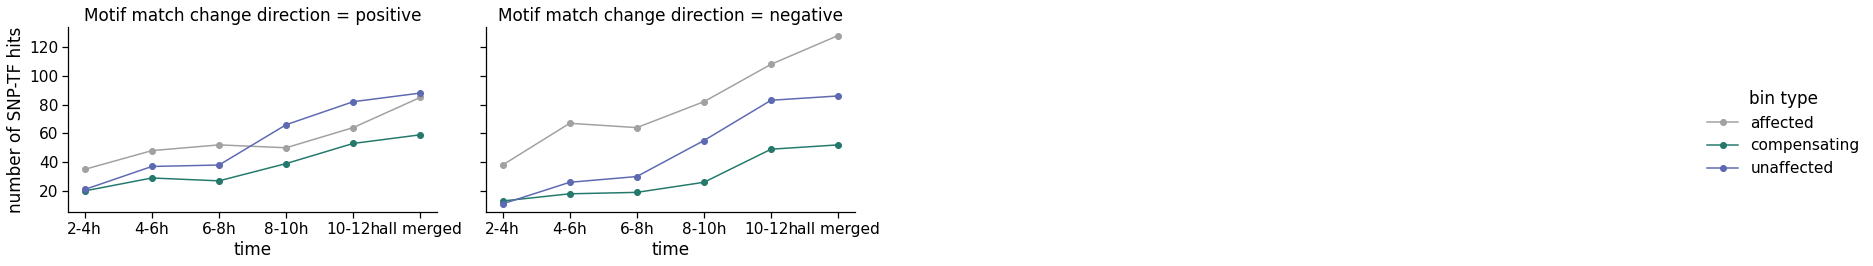

In [70]:
bin_type_palette ={"affected": "#a1a1a1", "compensating": "#24796c", "unaffected" : "#5d69b1"}

with sns.plotting_context('notebook', font_scale=1.4):
    grid = sns.FacetGrid(counts_df, col="Motif match change direction", hue = "bin type", col_wrap = 4, height=4, aspect=1.5, sharex=False, palette = bin_type_palette)
    grid.map(plt.plot, "time", "number of SNP-TF hits", marker="o")
    grid.add_legend()
    
plt.savefig(figures + "TF-SNPs_counts_bin_types.svg", bbox_inches='tight')

/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)



*** delta: 500, number of hits: 498 ***
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

negative_compensating vs. negative_unaffected bin: p=0.40
negative_affected vs. negative_compensating: p=0.21
positive_affected vs. positive_compensating: p=0.00
positive_compensating vs. positive_unaffected bin: p=0.24

*RESULTS FOR TFs*
             TF  Mann-Whitney U pvalue  mean alleleDiff in aff  \
5   FBgn0001180               0.000640               -0.444080   
20  FBgn0004870               0.007929               -2.437089   
59  FBgn0262636               0.032907               -0.908300   
66  FBgn0267821               0.015191               -1.720857   

    mean alleleDiff in ctrl  affected count  ctrl count  \
5                  3.850544              15           9   
20                 3.824207               9           3   
59                 1.564747    

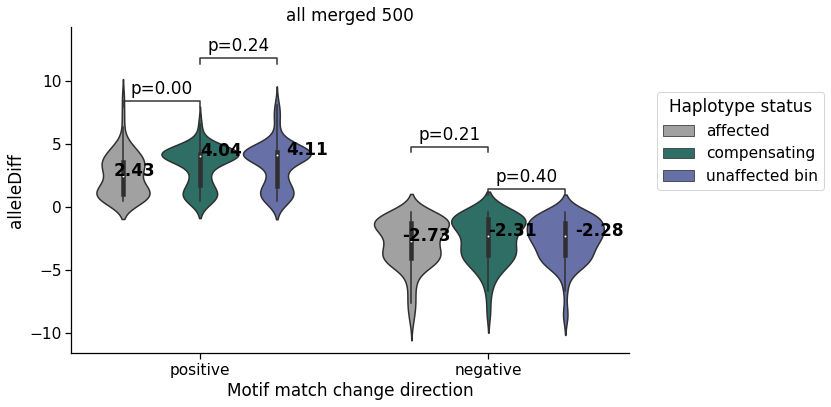

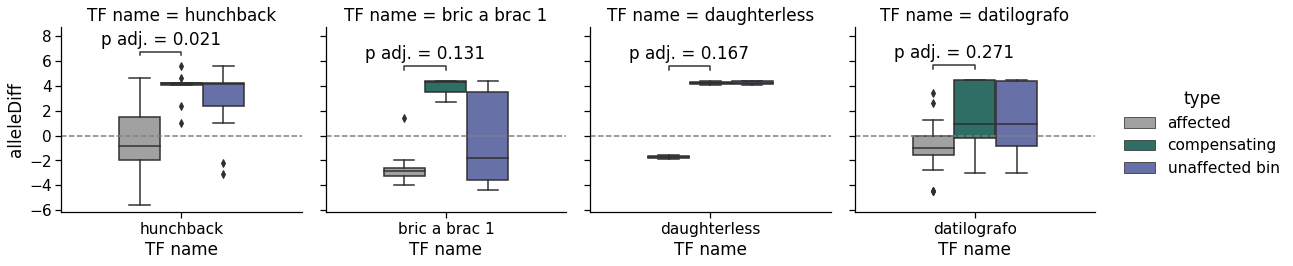

In [71]:
d = 500
time = "all merged"
dnase_gff = peaks_time_points[time]

motifbreakr_in_peaks = select_snps_in_peaks(dnase_gff, motifbreakr_all_dedup, delta = d)
print("\n*** delta: {}, number of hits: {} ***".format(d, len(motifbreakr_in_peaks)))        
       
pvalues, counts_hits, counts_snps = global_boxplots(motifbreakr_in_peaks.drop_duplicates(), 
                    title = time + " " + str(d), 
                    figure_name="global_alleleDiff_boxplots_{}_d{}".format(time,d))

print("\n*RESULTS FOR TFs*")
mwu_for_tfs(motifbreakr_in_peaks, "TFs_alleleDiff_boxplots_{}_d{}".format(time,d))       


In [72]:
pvalues

[0.213205144329918,
 0.3977184867558008,
 0.001666168819032412,
 0.24448295035933187]

In [73]:
motifbreakr_in_peaks.head()

,seqnames,start,end,width,strand,SNP_id,REF,ALT,varType,motifPos,...,Refpvalue,Altpvalue,altPos,alleleDiff,effect,haplotype,bin type,haplotype status,FlyBase ID,name for bed
0,chrX,5818881,5818881,1,+,chrX:5818881:G:A,G,A,SNV,"c(-5, 9)",...,.,.,1,-3.736229,strong,57,affected bin,affected,FBgn0036179,CG7368 -3.74 57
1,chrX,5818881,5818881,1,+,chrX:5818881:G:A,G,A,SNV,"c(-5, 9)",...,.,.,1,-1.589963,strong,57,affected bin,affected,FBgn0265276,l(3)neo38 -1.59 57
2,chr2L,3786208,3786208,1,-,chr2L:3786208:C:G,C,G,SNV,"c(-2, 8)",...,.,.,1,-4.394449,strong,57,affected bin,affected,FBgn0034946,CG3065 -4.39 57
3,chr2L,3786208,3786208,1,-,chr2L:3786208:C:G,C,G,SNV,"c(-4, 9)",...,.,.,1,-8.518651,strong,57,affected bin,affected,FBgn0034946,CG3065 -8.52 57
4,chr2L,3786208,3786208,1,-,chr2L:3786208:C:G,C,G,SNV,"c(-4, 10)",...,.,.,1,-6.917077,strong,57,affected bin,affected,FBgn0034946,CG3065 -6.92 57


In [74]:
hb_da_motifbreakr_merged_peaks = motifbreakr_in_peaks[motifbreakr_in_peaks["FlyBase ID"].isin(["FBgn0001180", "FBgn0267821"])].copy()
hb_da_motifbreakr_merged_peaks["name for bed"] = hb_da_motifbreakr_merged_peaks["geneSymbol"] + ' ' + hb_da_motifbreakr_merged_peaks["alleleDiff"].apply(lambda x: '{0:.2f}'.format(x)) \
+ ' ' + hb_da_motifbreakr_merged_peaks["haplotype"].astype(str) + " " + hb_da_motifbreakr_merged_peaks["haplotype status"]
hb_da_motifbreakr_merged_peaks[["seqnames", "start", "end", "name for bed"]].to_csv("../../results_final/bed/hb_da_motifbreakr_merged_peaks.bed", sep = "\t", index = False, header = False)

In [75]:
!head ../../results_final/bed/hb_da_motifbreakr_merged_peaks.bed

chr2L	10947977	10947977	hb 0.45 57 affected
chr3R	29081742	29081742	hb 3.79 57 affected
chr3R	29081742	29081742	hb 1.58 57 affected
chr2R	25101934	25101934	da -1.83 57 affected
chr2R	25101934	25101934	da -1.85 57 affected
chr2R	25243296	25243296	hb -0.93 57 affected
chr2R	6460420	6460420	da 4.39 57 CTRL
chr2R	6460420	6460420	da 4.26 57 CTRL
chr3R	13839820	13839820	hb 4.11 57 CTRL
chr3R	13839820	13839820	hb 4.23 57 CTRL


# Plot motif changes for selected hits

In [76]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [77]:
%%R 

library(motifbreakR)
library(BSgenome.Dmelanogaster.custom.dgrp57)
library(BSgenome.Dmelanogaster.custom.dgrp439)

In [78]:
%%R
plot_snp <- function(snp_id) {
    res = readRDS(file = paste("../../results_final/csv/WE_transUP.affected_bin.DGRP-57-affected.SNPs.439genome.motifbreakR", sep=""))  
    br <- res[res$SNP_id == snp_id]
    plotMB(results = br, rsid = snp_id)
}

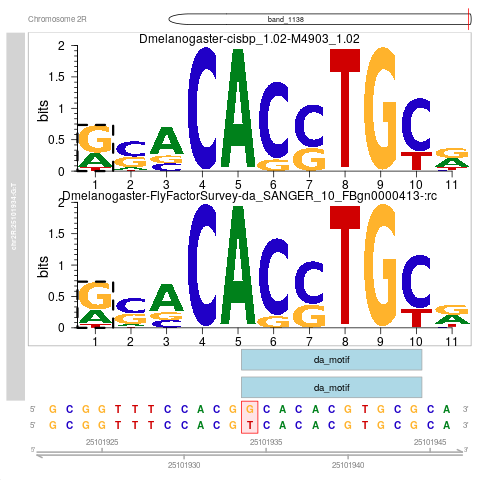

In [94]:
snp_id = "chr2R:25101934:G:T"
%Rpush snp_id
%R plot_snp(snp_id)    

In [98]:
motifbreakr_file = "../../results_final/csv/WE_transUP.affected_bin.DGRP-57-affected.SNPs.439genome.motifbreakR"
output_file = "../../results_final/fig/da_chr2R-25101934-G-T.pdf"
snp_id = "chr2R:25101934:G:T"
name = "da"
! Rscript ../R/plot_snp_tf_hit.R "$motifbreakr_file" "$output_file" "$snp_id" "$name"

Loading required package: grid
Loading required package: MotifDb
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Loading required package: S4Vectors
Loading required pac

In [99]:
%%R
plot_snp2 <- function(snp_id, name) {
    res = readRDS(file = paste("../../results_final/csv/WE_transUP.affected_bin.DGRP-439-affected.SNPs.57genome.motifbreakR", sep=""))  
    br <- res[res$SNP_id == snp_id]
    hb <- br[br$geneSymbol == name]
    plotMB(results = hb, rsid = snp_id)
}

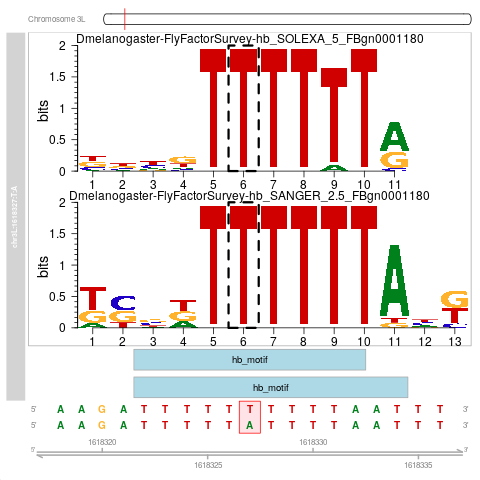

In [100]:
snp_id = "chr3L:1618327:T:A"
name = "hb"
%Rpush snp_id name
%R plot_snp2(snp_id, name)    

In [102]:
motifbreakr_file = "../../results_final/csv/WE_transUP.affected_bin.DGRP-439-affected.SNPs.57genome.motifbreakR"
output_file = "../../results_final/fig/hb_chr3L-1618327-T-A.pdf"
snp_id = "chr3L:1618327:T:A"
name = "hb"
! Rscript ../R/plot_snp_tf_hit.R "$motifbreakr_file" "$output_file" "$snp_id" "$name"

Loading required package: grid
Loading required package: MotifDb
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Loading required package: S4Vectors
Loading required pac